In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
from scipy.optimize import minimize
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
import scipy.stats as sps

myparams = {
    'text.usetex': True,
    'text.latex.preamble': r'\usepackage{amsfonts}',
    'font.family': 'Djvu Serif',
    'font.size': 16,
    'axes.grid': True,
    'grid.alpha': 0.1,
    'lines.linewidth': 2,
}

plt.rcParams.update(myparams)

from utils import Dataset
from models import RegressionModel, LogisticModel

%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2

# Линейная регрессия

Задана модель линейной регрессии:
$$ \mathbf{X} \in \mathbb{R}^{m \times n}, \qquad \mathbf{y} \in \mathbb{R}^{m}, \qquad \mathbf{w} \in \mathbb{R}^{n}, $$
$$ p(\mathbf{y}, \mathbf{w}, \mathbf{X} | \alpha) = \prod_{i=1}^{m} \mathcal{N}(\mathbf{x}_i | \boldsymbol{\mu}_{\mathbf{x}}, \mathbf{\Sigma}_{\mathbf{x}}) \mathcal{N}(\mathbf{w} | \mathbf{0}, \alpha^{-1} \mathbf{I}_n) \prod_{i=1}^{m} p(y_i | \mathbf{x}_i, \mathbf{w}), $$
$$ p(y_i | \mathbf{x}_i, \mathbf{w}) = \mathcal{N}(y_i | \mathbf{w}^\top \mathbf{x}_i,  \sigma^2). $$

Обозначим априорное распределение параметров
$$ p(\mathbf{w}) = \mathcal{N} \left( \mathbf{w} | \mathbf{m}_0, \mathbf{\Sigma}_0 \right), $$
где чаще всего будут встречаться $\mathbf{m}_0 = \mathbf{0}$ и $\mathbf{\Sigma}_0 = \alpha^{-1} \mathbf{I}$.
Апостериорное распределение параметров:
$$ p(\mathbf{w} | \mathbf{X}, \mathbf{y}) = \mathcal{N}\left( \mathbf{w} | \mathbf{m}, \mathbf{\Sigma} \right), $$
где математическое ожидание и ковариационная матрица есть
$$ \mathbf{\Sigma} = \left( \mathbf{\Sigma}_0^{-1} + \dfrac{1}{\sigma^2} \mathbf{X}^\top \mathbf{X} \right)^{-1}, $$
$$ \mathbf{m} = \mathbf{\Sigma} \left( \dfrac{1}{\sigma^2} \mathbf{X}^\top \mathbf{y} + \mathbf{\Sigma}_0^{-1} \mathbf{m}_0 \right). $$

Пусть заданы две подвыборки размера $k$ и $k+1$. Рассмотрим апостериорное распредление параметров, полученное по каждой из подвыборок:
$$ p_k(\mathbf{w}) = p(\mathbf{w} | \mathbf{X}_k, \mathbf{y}_k) = \mathcal{N}\left( \mathbf{w} | \mathbf{m}_k, \mathbf{\Sigma}_k \right). $$

Если размер выбор достаточен, то эти апостериорные распредления должны быть похожи. Их схожесть можно толковать по-разному.

## Дивергенция Кульбака-Лейблера

Для нормальных распределений известна формула дивергенции Кульбака-Лейблера. Применяя ее, находим
$$ D_{KL}\left( p_k \| p_{k+1} \right) = \dfrac{1}{2} \left( \mathrm{tr}\left( \mathbf{\Sigma}_{k+1}^{-1} \mathbf{\Sigma}_k \right) + (\mathbf{m}_{k+1} - \mathbf{m}_k)^\top \mathbf{\Sigma}_{k+1}^{-1} (\mathbf{m}_{k+1} - \mathbf{m}_k) - n + \log{\left( \dfrac{\det \mathbf{\Sigma}_{k+1}}{\det \mathbf{\Sigma}_{k}} \right)} \right). $$

In [3]:
def KL(mk, Sk, mkp1, Skp1):
    return 1/2 * (np.trace(np.linalg.inv(Skp1) @ Sk) + (mkp1 - mk) @ np.linalg.inv(Skp1) @ (mkp1 - mk) - mk.size + np.log(np.linalg.det(Skp1) / np.linalg.det(Sk)))

In [4]:
m = 100
n = 20

mu_x = np.zeros(n)
Sigma_x = np.identity(n)

sigma2 = 1

alpha = 1
m0 = np.zeros(n)
Sigma0 = alpha**(-1) * np.identity(n)

In [5]:
X = sps.multivariate_normal(mean=mu_x, cov=Sigma_x).rvs(size=m)
w = sps.multivariate_normal(mean=m0, cov=Sigma0).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [6]:
dataset = Dataset(X, y)

In [7]:
def posterior_parameters(m0, Sigma0, X, y, sigma2=1):
    Sigma = np.linalg.inv(np.linalg.inv(Sigma0) + 1/sigma2 * X.T @ X)
    m = Sigma @ (1/sigma2 * X.T @ y + np.linalg.inv(Sigma0) @ m0)
    return m, Sigma

Последовательно удаляем один случайный объект из выборки. Делаем так, пока не дойдем до количества объектов = количеству признаков. Повторяем такой процесс N раз и усредняем результаты.

In [8]:
N = 100
matrix = []

for _ in range(N): # делаем усреднение по 100 проходам

    divergences = []

    k = m-1
    Xkp1, ykp1 = X, y
    mkp1, Skp1 = posterior_parameters(m0, Sigma0, Xkp1, ykp1)
    
    while k > n:
        index = np.random.randint(k)
        Xk, yk = np.delete(Xkp1, index, axis=0), np.delete(ykp1, index, axis=0)
        mk, Sk = posterior_parameters(m0, Sigma0, Xk, yk)
        divergences.append(KL(mk, Sk, mkp1, Skp1))
        Xkp1, ykp1 = Xk, yk
        mkp1, Skp1 = mk, Sk
        k -= 1
        
    matrix.append(divergences)
    
matrix = np.array(matrix)

In [14]:
means = matrix.mean(axis=0)[::-1]
stds = matrix.std(axis=0)[::-1]

In [15]:
sample_sizes = np.arange(n+1, m)

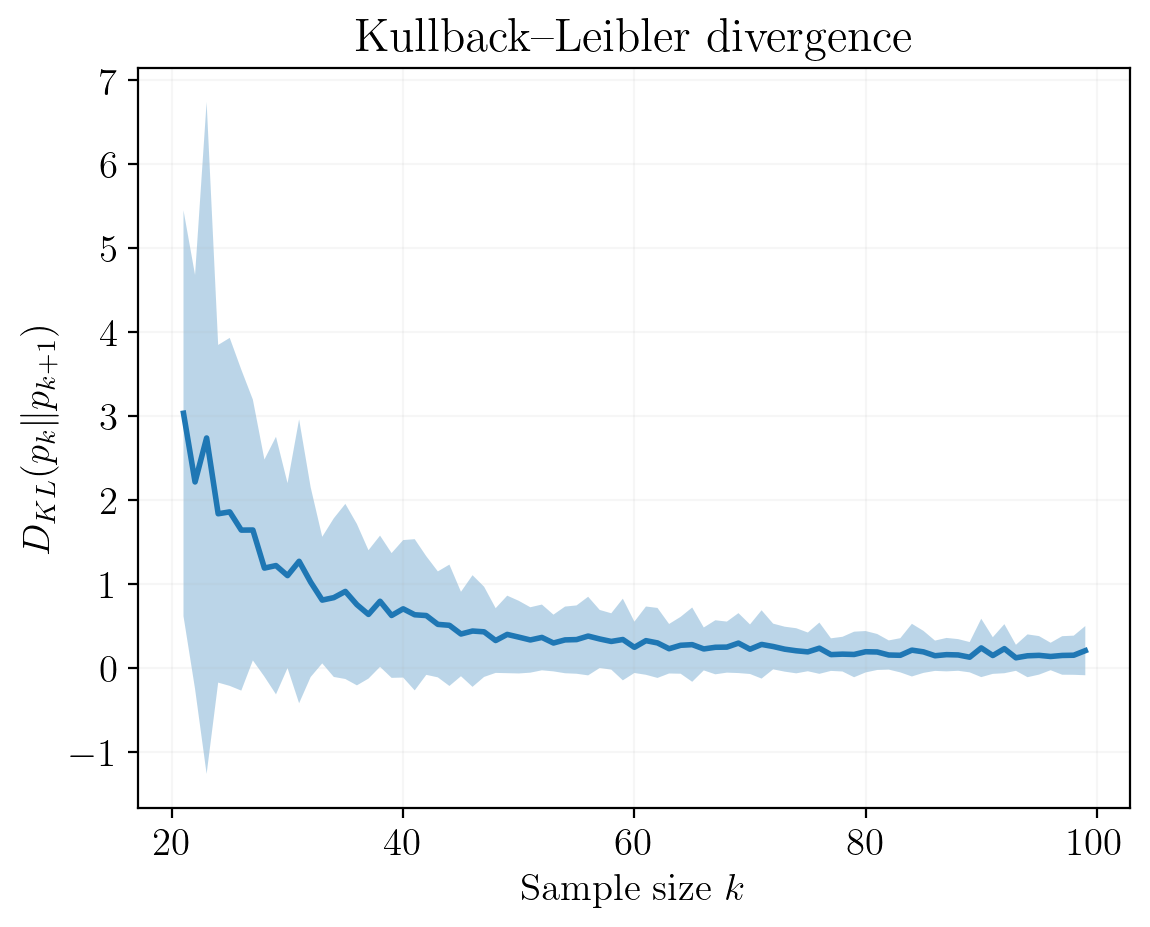

In [16]:
plt.plot(sample_sizes, means)
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)
plt.title("Kullback–Leibler divergence")
plt.xlabel(r"Sample size $k$")
plt.ylabel(r"$D_{KL}(p_k \| p_{k+1})$")
plt.show()

## s-score

Функция близости s-score была предложена Адуенко в 2014 году. Является корректной функцией близости. Принимает значения от 0, когда распределения различны, до 1, когда они близки. Для нормальных распределений она имеет следующий вид
$$ s(p_k, p_{k+1}) = \exp{\left( -\dfrac{1}{2} (\mathbf{m}_{k+1} - \mathbf{m}_k)^\top \left( \mathbf{\Sigma}_k + \mathbf{\Sigma}_{k+1} \right)^{-1} (\mathbf{m}_{k+1} - \mathbf{m}_k) \right)}. $$

In [17]:
def s_score(mk, Sk, mkp1, Skp1):
    return np.exp(-1/2 * ((mkp1 - mk) @ np.linalg.inv(Sk + Skp1) @ (mkp1 - mk)))

Последовательно удаляем один случайный объект из выборки. Делаем так, пока не дойдем до количества объектов = количеству признаков. Повторяем такой процесс N раз и усредняем результаты.

In [18]:
N = 100
matrix = []

for _ in range(N): # делаем усреднение по 100 проходам

    scores = []

    k = m-1
    Xkp1, ykp1 = X, y
    mkp1, Skp1 = posterior_parameters(m0, Sigma0, Xkp1, ykp1)
    
    while k > n:
        index = np.random.randint(k)
        Xk, yk = np.delete(Xkp1, index, axis=0), np.delete(ykp1, index, axis=0)
        mk, Sk = posterior_parameters(m0, Sigma0, Xk, yk)
        scores.append(s_score(mk, Sk, mkp1, Skp1))
        Xkp1, ykp1 = Xk, yk
        mkp1, Skp1 = mk, Sk
        k -= 1
        
    matrix.append(scores)
    
matrix = np.array(matrix)

In [19]:
means = matrix.mean(axis=0)[::-1]
stds = matrix.std(axis=0)[::-1]

In [20]:
sample_sizes = np.arange(n+1, m)

In [25]:
plt.plot(sample_sizes, means)
plt.fill_between(sample_sizes, means - stds, means + stds, alpha=0.3)
plt.title("s-score")
plt.xlabel(r"Sample size $k$")
plt.ylabel(r"$\text{s-score}(p_k, p_{k+1})$")
plt.show()

RuntimeError: latex was not able to process the following string:
b'$\\\\text{s-score}(p_k, p_{k+1})$'

Here is the full command invocation and its output:

latex -interaction=nonstopmode --halt-on-error --output-directory=tmp6vfjnr7y 594b9c3632573bfc3292724f579af1da.tex

This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) (preloaded format=latex)
 restricted \write18 enabled.
entering extended mode
(./594b9c3632573bfc3292724f579af1da.tex
LaTeX2e <2022-11-01> patch level 1
L3 programming layer <2023-02-22>
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/article.cls
Document Class: article 2022/07/02 v1.4n Standard LaTeX document class
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/size10.clo))
(/usr/local/texlive/2023/texmf-dist/tex/latex/type1cm/type1cm.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/cm-super/type1ec.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/t1cmr.fd))
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/inputenc.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/geometry/geometry.sty
(/usr/local/texlive/2023/texmf-dist/tex/latex/graphics/keyval.sty)
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/ifvtex.sty
(/usr/local/texlive/2023/texmf-dist/tex/generic/iftex/iftex.sty)))
(/usr/local/texlive/2023/texmf-dist/tex/latex/amsfonts/amsfonts.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/underscore/underscore.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/base/textcomp.sty)
(/usr/local/texlive/2023/texmf-dist/tex/latex/l3backend/l3backend-dvips.def)
No file 594b9c3632573bfc3292724f579af1da.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Undefined control sequence.
<recently read> \text 
                      
l.29 {\rmfamily $\text
                      {s-score}(p_k, p_{k+1})$}%
No pages of output.
Transcript written on tmp6vfjnr7y/594b9c3632573bfc3292724f579af1da.log.




<Figure size 640x480 with 1 Axes>

# Визуализация сходимости апостериорных распределений

## Одномерный случай (размерность вектора признаков = 1)

In [418]:
m = 100
n = 1

mu_x = np.zeros(n)
Sigma_x = np.identity(n)

sigma2 = 1

alpha = 1
m0 = np.zeros(n)
Sigma0 = alpha**(-1) * np.identity(n)

In [419]:
np.random.seed(42)

X = sps.norm(mu_x, Sigma_x).rvs(size=m)
w = sps.norm(m0, Sigma0).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X * w + eps

In [420]:
def posterior_parameters(m0, Sigma0, X, y, sigma2=1):
    Sigma = np.linalg.inv(np.linalg.inv(Sigma0) + 1/sigma2 * X.T @ X)
    m = Sigma @ (1/sigma2 * X.T @ y + np.linalg.inv(Sigma0) @ m0)
    return m, Sigma

In [421]:
mu, Sigma = posterior_parameters(m0, Sigma0, X, y, sigma2)

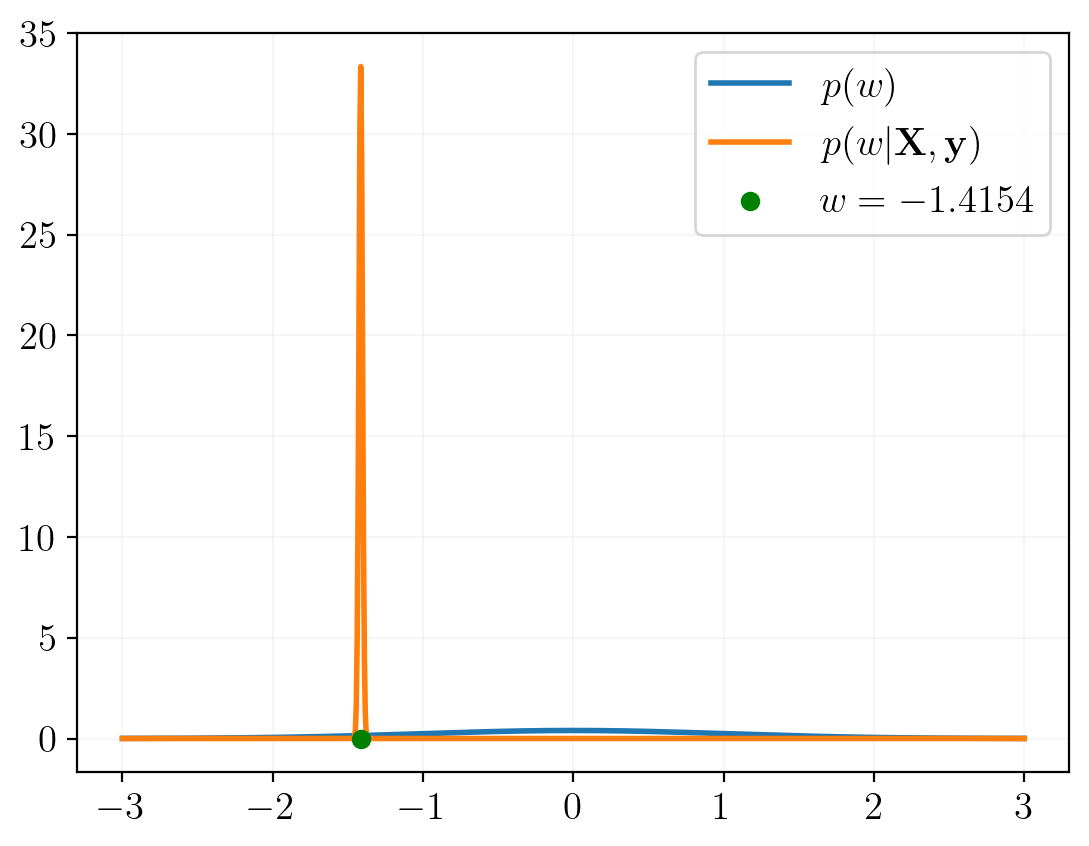

In [422]:
grid = np.linspace(-3, 3, 1000)

plt.plot(grid, sps.norm(m0, Sigma0).pdf(grid).reshape(-1), label=r"$p(w)$")
plt.plot(grid, sps.norm(mu, Sigma).pdf(grid).reshape(-1), label=r"$p(w|\mathbf{X}, \mathbf{y})$")
plt.scatter(w, 0, color='green', zorder=2, label=f"$w = {w[0]:.4f}$")
plt.legend()
#plt.ylim(0, 1)
plt.show()

In [423]:
B = 100
matrix = []

for _ in range(B): # делаем усреднение по 100 проходам

    parameters = []

    for k in range(1, m+1):
        indices = np.random.permutation(m)[:k]
        Xk, yk = X[indices], y[indices]
        mu, Sigma = posterior_parameters(m0, Sigma0, Xk, yk, sigma2)
        mu, sigma = mu[0], Sigma[0][0]
        parameters.append(np.array([mu, sigma]))
        
    matrix.append(parameters)
    
matrix = np.array(matrix)
matrix = matrix.mean(axis=0)

/var/folders/dc/qxr0bswj3hg3wmy8gfl335340000gn/T/ipykernel_83927/2563579375.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


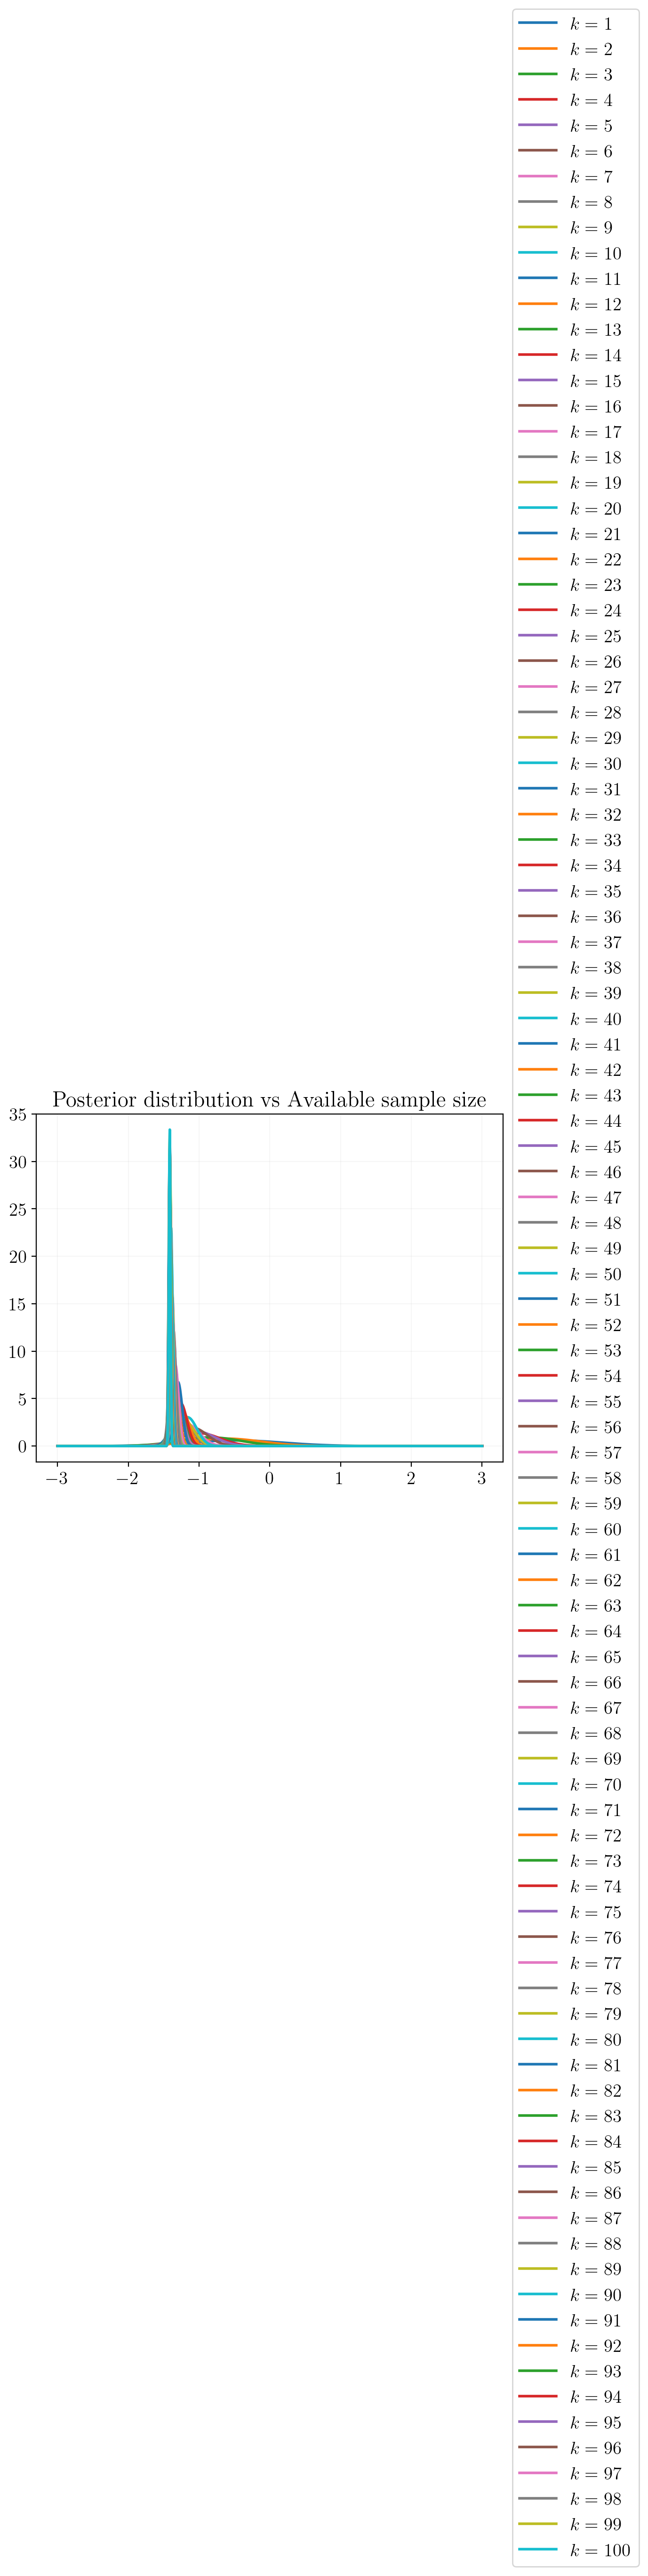

In [424]:
grid = np.linspace(-3, 3, 1000)

for idx, (mu, sigma) in enumerate(matrix):
    plt.plot(grid, sps.norm(mu, sigma).pdf(grid), label=f"$k = {idx+1}$")

plt.legend(bbox_to_anchor=(1, 0.5), loc="center left")
plt.title("Posterior distribution vs Available sample size")
plt.tight_layout()
plt.show()

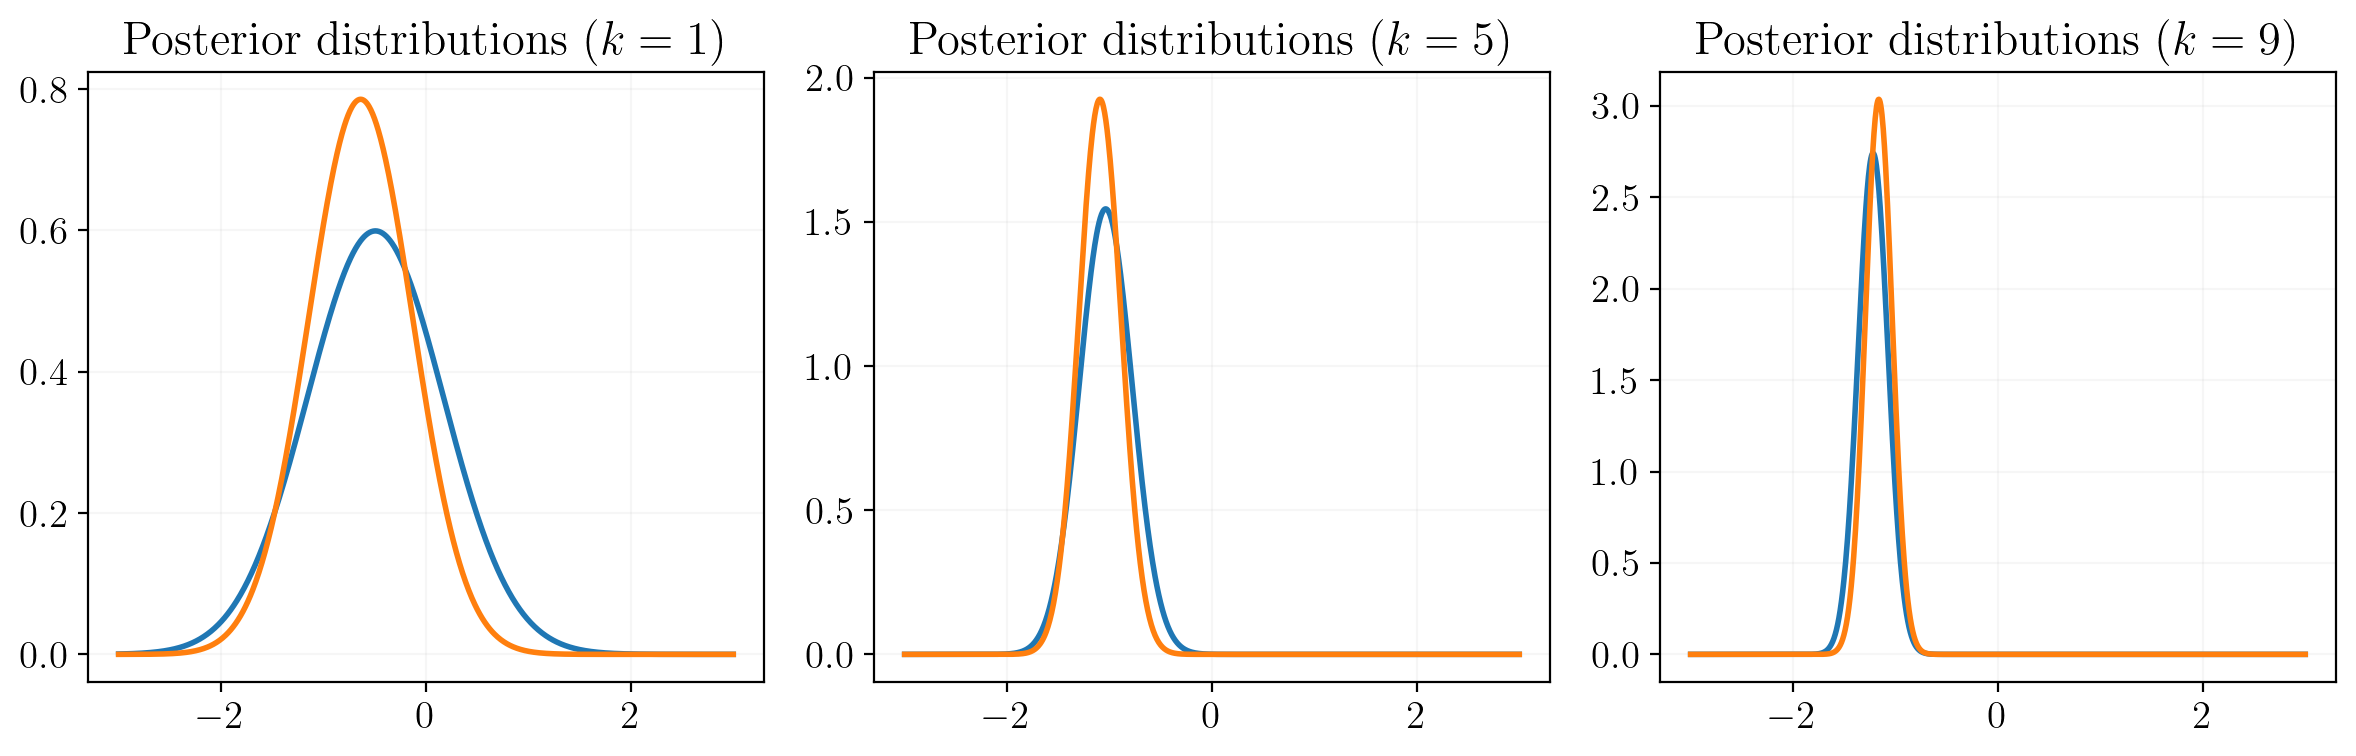

In [425]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for i, k in enumerate([1, 5, 9]):
    mu_k, sigma_k = matrix[k-1]
    mu_kp1, sigma_kp1 = matrix[k]
    ax[i].plot(grid, sps.norm(mu_k, sigma_k).pdf(grid))
    ax[i].plot(grid, sps.norm(mu_kp1, sigma_kp1).pdf(grid))
    ax[i].set_title(f"Posterior distributions ($k = {k}$)")

plt.tight_layout()
plt.show()

## Двумерный случай (размерность вектора признаков = 2)

In [409]:
m = 100
n = 2

mu_x = np.zeros(n)
Sigma_x = np.identity(n)

sigma2 = 1

alpha = 1
m0 = np.zeros(n)
Sigma0 = alpha**(-1) * np.identity(n)

In [410]:
np.random.seed(3067)

X = sps.multivariate_normal(mean=mu_x, cov=Sigma_x).rvs(size=m)
w = sps.multivariate_normal(mean=m0, cov=Sigma0).rvs(size=1)
eps = sps.multivariate_normal(mean=np.zeros(m), cov=sigma2*np.identity(m)).rvs(size=1)
y = X @ w + eps

In [411]:
mu, Sigma = posterior_parameters(m0, Sigma0, X, y, sigma2)

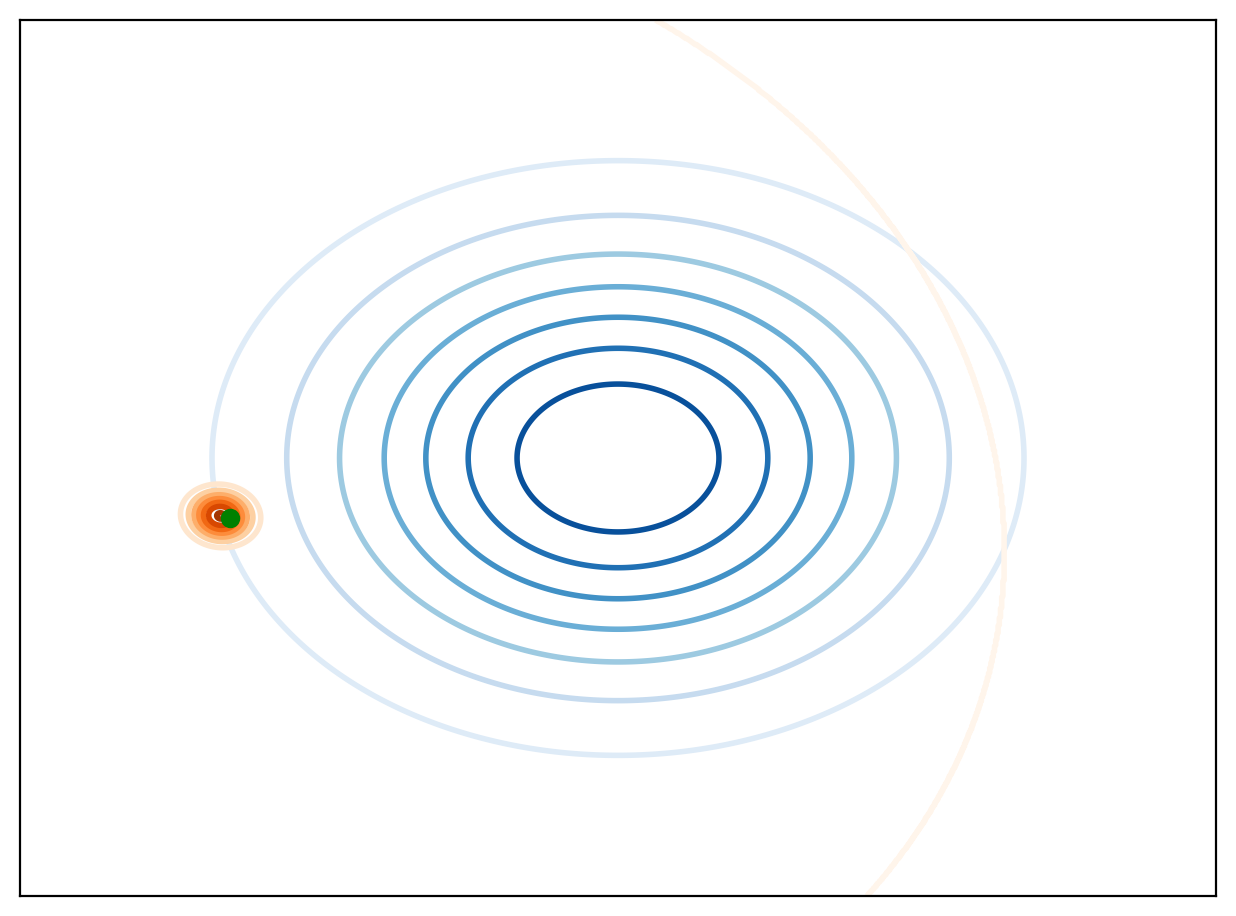

In [412]:
prior = sps.multivariate_normal(m0, Sigma0) # более широкий
posterior = sps.multivariate_normal(mu, Sigma) # более узкий

grid_x = np.linspace(-3, 3, 1000)
grid_y = np.linspace(-3, 3, 1000)

meshgrid_x, meshgrid_y = np.meshgrid(grid_x, grid_y)
meshgrid = np.stack((meshgrid_x, meshgrid_y), axis=-1)

plt.contour(meshgrid_x, meshgrid_y, prior.pdf(meshgrid), cmap='Blues')
plt.contour(meshgrid_x, meshgrid_y, posterior.pdf(meshgrid), cmap='Oranges')
plt.plot(w[0], w[1], color='green', marker='o') # настоящее значение
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

In [413]:
B = 100
matrix_mu = []
matrix_Sigma = []

for _ in range(B): # делаем усреднение по 100 проходам

    mus = []
    Sigmas = []

    for k in range(1, m+1):
        indices = np.random.permutation(m)[:k]
        Xk, yk = X[indices], y[indices]
        mu, Sigma = posterior_parameters(m0, Sigma0, Xk, yk, sigma2)
        mus.append(mu)
        Sigmas.append(Sigma)
        
    matrix_mu.append(mus)
    matrix_Sigma.append(Sigmas)
    
matrix_mu = np.array(matrix_mu).mean(axis=0)
matrix_Sigma = np.array(matrix_Sigma).mean(axis=0)

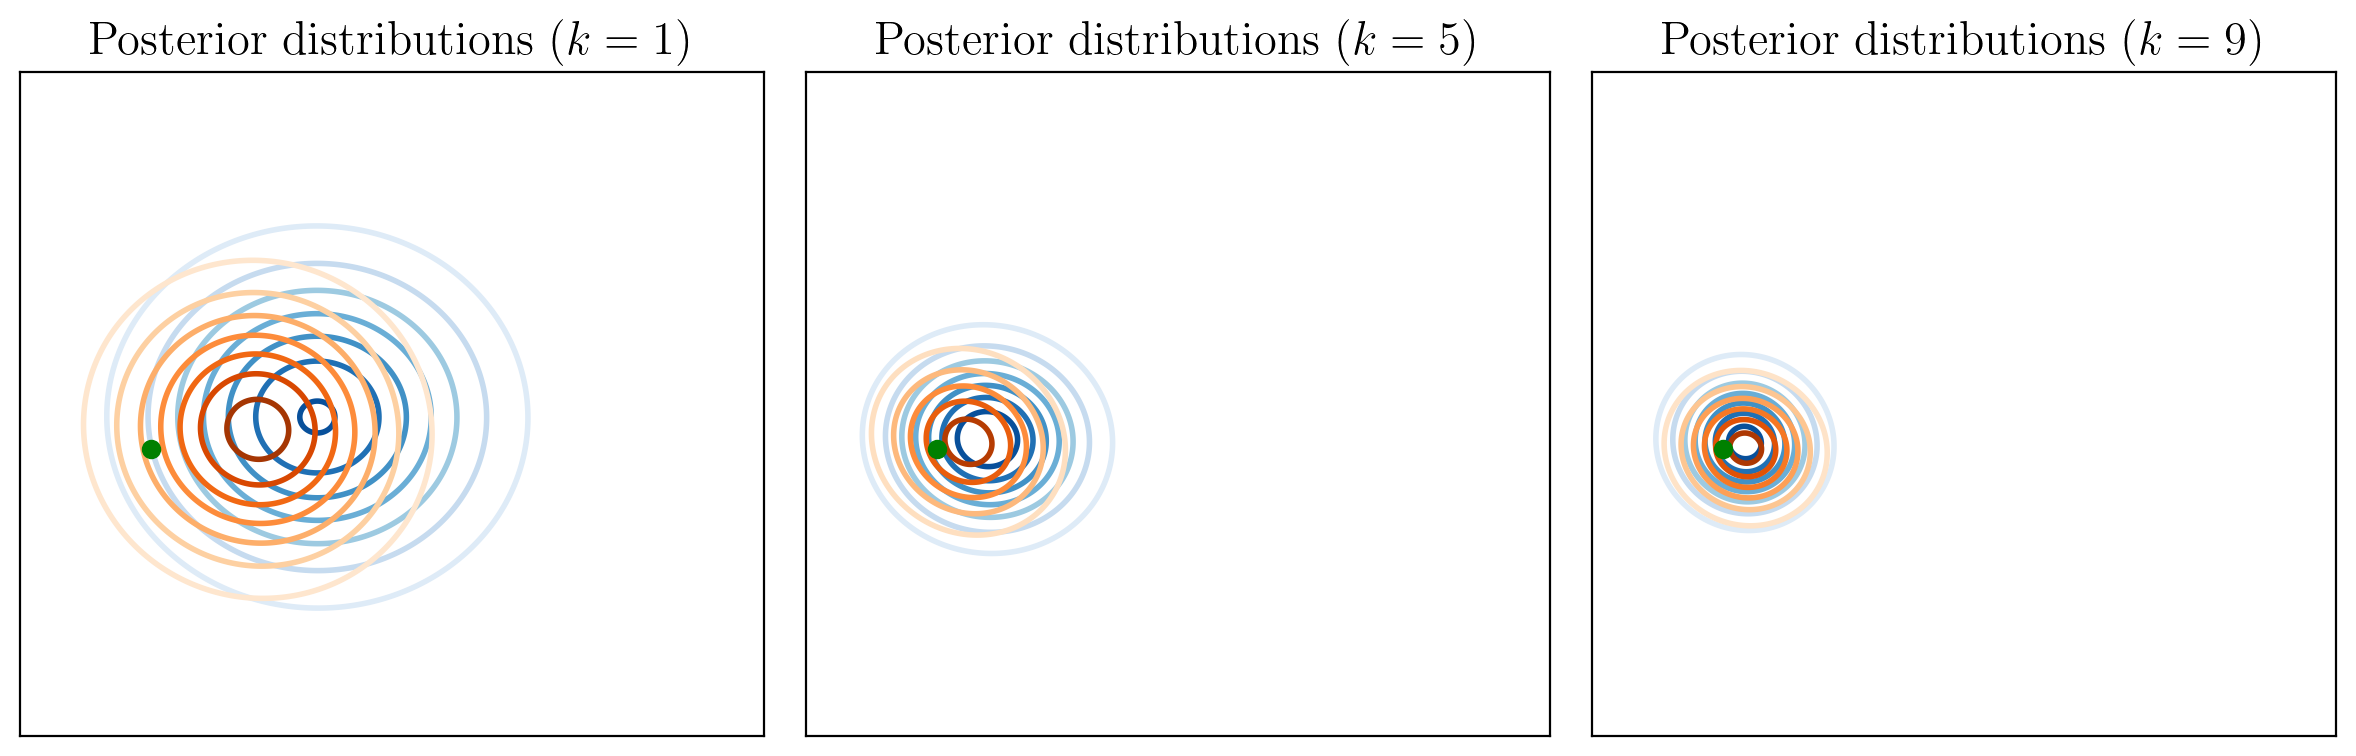

In [417]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

grid_x = np.linspace(-3, 3, 1000)
grid_y = np.linspace(-3, 3, 1000)

meshgrid_x, meshgrid_y = np.meshgrid(grid_x, grid_y)
meshgrid = np.stack((meshgrid_x, meshgrid_y), axis=-1)

for i, k in enumerate([1, 5, 9]):
    mu_k, Sigma_k = matrix_mu[k-1], matrix_Sigma[k-1]
    distr_k = sps.multivariate_normal(mu_k, Sigma_k)
    mu_kp1, Sigma_kp1 = matrix_mu[k], matrix_Sigma[k]
    distr_kp1 = sps.multivariate_normal(mu_kp1, Sigma_kp1)
    ax[i].contour(meshgrid_x, meshgrid_y, distr_k.pdf(meshgrid), cmap='Blues')
    ax[i].contour(meshgrid_x, meshgrid_y, distr_kp1.pdf(meshgrid), cmap='Oranges')
    ax[i].plot(w[0], w[1], color='green', marker='o') # настоящее значение
    ax[i].set_title(f"Posterior distributions ($k = {k}$)")

plt.setp(ax, xticks=[], yticks=[])
plt.tight_layout()
plt.show()